# 1.0 Create random sky in Temperature

In this section we learn how to create a random sky realization out of a real model of Unverse. First of all, we have to start from the DlTT file. It contains the TT power spectrum measured by Planck.

In [ ]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline


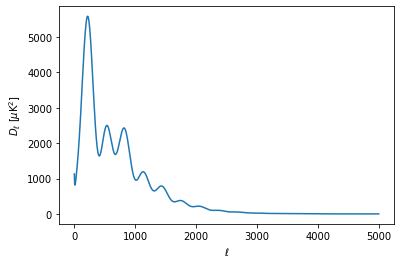

In [ ]:
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
# Temperature angular power-spectrum
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

In [ ]:
def make_CMB_T_map(N,pix_size,ell,DlTT):
    #makes a realization of a simulated CMB sky map given an input DlTT as a function of ell, 
    #the pixel size (pix_size) required and the number N of pixels in the linear dimension.
    
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # comput 
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)

    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector
    
    
    
    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

In [ ]:
# A smart routine to convert spherical sky_patch into a flat-map

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

map mean: -4.287535191233134 map rms: 96.61275807786757


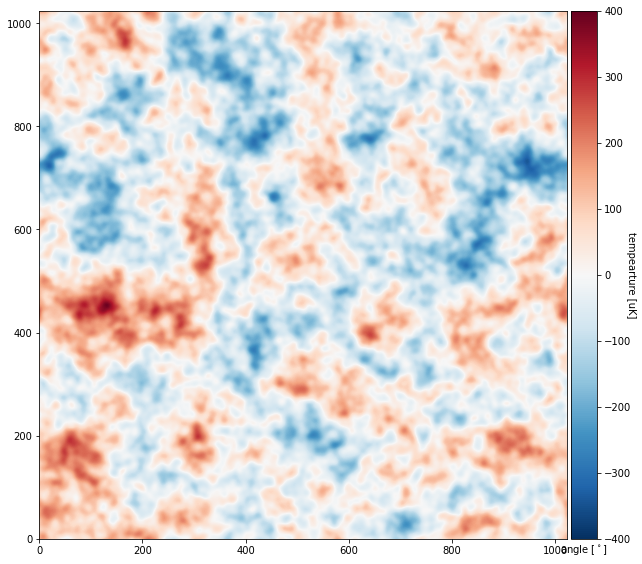

0

In [ ]:
N = 1024
pix_size = 0.5
c_min = -400
c_max = 400
X_width = Y_width = 1024

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)

# 2.0 Add the galaxy clusters - the SZ effect

The Sunyaev–Zeldovich effect (named after Rashid Sunyaev and Yakov B. Zeldovich and often abbreviated as the SZ effect) is the distortion of the cosmic microwave background (CMB) through inverse Compton scattering by high-energy electrons in galaxy clusters, in which the low-energy CMB photons receive an average energy boost during collision with the high-energy cluster electrons. Observed distortions of the cosmic microwave background spectrum are used to detect the disturbance of density in the universe.

In [ ]:
def SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros([N,N])
    SZcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZMap[pix_x,pix_y] += pix_amplitude
        i = i + 1
    
    # make a beta function
    beta = beta_function(int(N),pix_size,SZ_beta,SZ_Theta_core)
 
    print("Massimo: ",np.amax(beta))
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZMap)))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)
    print(np.amin(R), np.amax(R))

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map
Number_of_SZ_Clusters  = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
SZ_Theta_core = 1.0

SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,True)

0.3535533905932738 361.6851185769191
Massimo:  0.9111492190368407


map mean: -18.65216054311441 map rms: 96.78805196645646


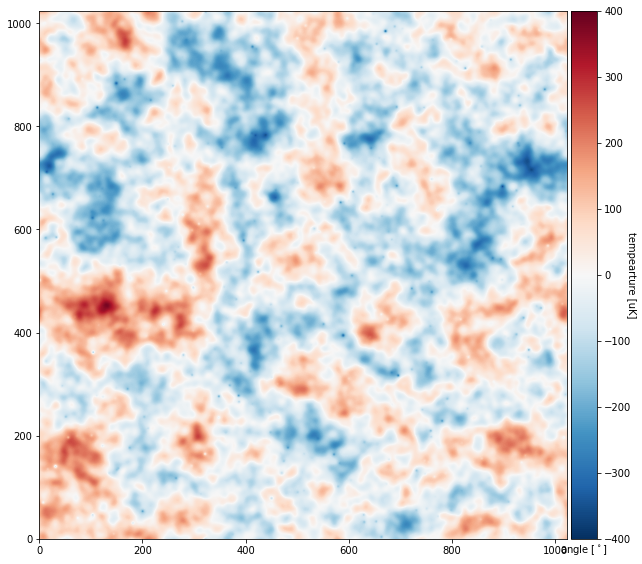

0

In [ ]:
Plot_CMB_Map(CMB_T+SZMap,c_min,c_max,X_width,Y_width)

# 3.0 Beam convolution - satellite approach

In this notebook I show you how to convolve the map with the beam shape of your telescope. Let's consider the telescope response like a gaussian beam. If we are looking for simulation of the whole telescope response, included the beam shape, we have to convolve the starting map with the beam shape and then use the an NSIDE value of the map just as a function of the frequency-sample. In this case we don't use the NSIDE parameter because we are plotting flat-maps. The NSIDE parameter is related to the [healpix](https://healpix.jpl.nasa.gov/) sky representation

map mean: -18.6521605431144 map rms: 96.39291154080476


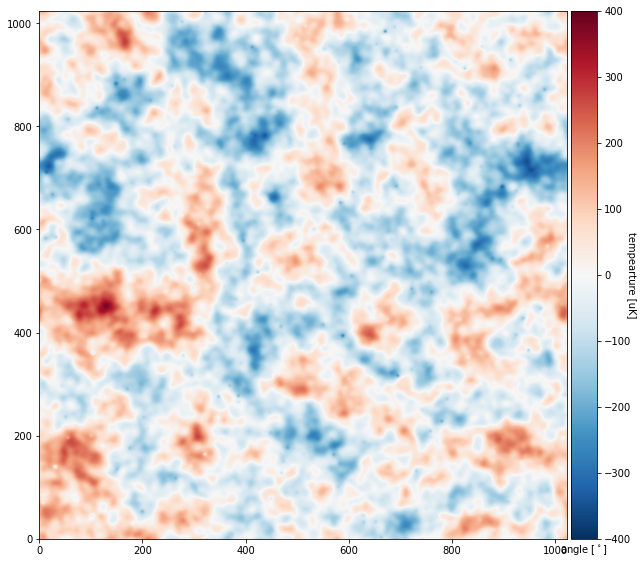

map mean: -18.65216054311441 map rms: 96.78805196645646


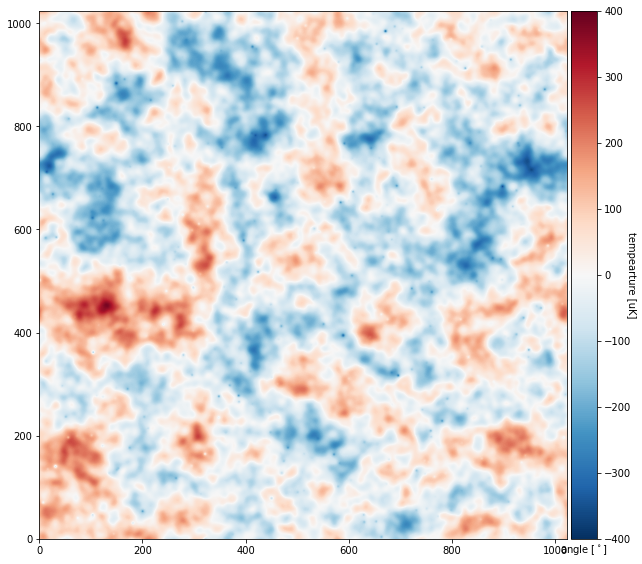

map mean: 2.8783377265870516 map rms: 2.3453834835913008


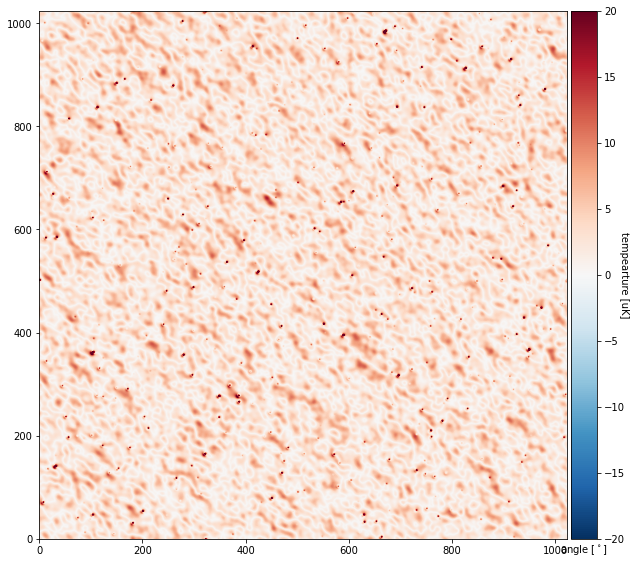

In [ ]:
beam_size_fwhp = 1.5

def convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,Map):
    "convolves a map with a Gaussian beam pattern.  NOTE: pix_size and beam_size_fwhp need to be in the same units" 
    # make a 2d gaussian 
    gaussian = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)
  
    # do the convolution
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian)) # first add the shift so that it is central
    FT_Map = np.fft.fft2(np.fft.fftshift(Map)) #shift the map too
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map))) 
    
    # return the convolved map
    return(convolved_map)
  ###############################   

def make_2d_gaussian_beam(N,pix_size,beam_size_fwhp):
     # make a 2d coordinate system
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    #plt.title('Radial co ordinates')
    #plt.imshow(R)
  
    # make a 2d gaussian 
    beam_sigma = beam_size_fwhp / np.sqrt(8.*np.log(2))
    gaussian = np.exp(-.5 *(R/beam_sigma)**2.)
    gaussian = gaussian / np.sum(gaussian)
    # return the gaussian
    #plt.imshow(gaussian)
    return(gaussian)
  ###############################  
    
    
## convolve the signal part of the map

SKY_MAP = CMB_T + SZMap
CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp, SKY_MAP)

# Convolved map
p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width)
# Starting map
p=Plot_CMB_Map(SKY_MAP,c_min,c_max,X_width,Y_width)
# Differences between them.
p=Plot_CMB_Map(np.abs(SKY_MAP-CMB_T_convolved),-20,20,X_width,Y_width)

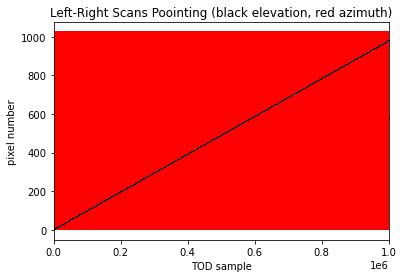

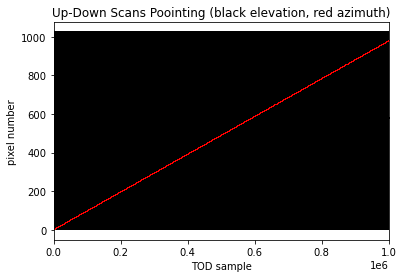

In [ ]:
def sim_pointing(map, dir=0):
    """Simulate a telescope scanning across the given map. The scanning pattern is
    as simple as possible: The samples hit the center of each pixel, and we
    scan rowwise (dir=0) or columnwise (dir=1)."""
    # The pointing is an [{y,x},nsamp] array of pixel positions
    # The einsum stuff is just to swap the second and third axis
    # of pixmap, which contains the pixel coordinates of each pixel.
    pixmap = np.mgrid[:map.shape[-2],:map.shape[-1]]  ## makes two arrays of the x and y indices in the map
    pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]## reverse ever other row so the scans go back and forth
    
    if dir == 0: 
        point = pixmap.reshape(2,-1)         ## arranges these for L-R scans
    else:        
        point = np.roll(pixmap,1,axis=0).reshape(2,-1)   ## arranges these for U-D scans
    return point

## generate left-right scans
point_lr = sim_pointing(CMB_T, 0)

## generate Up-Down scans
point_ud = sim_pointing(CMB_T, 1)
plt.plot(point_lr[1,:],"r,")
plt.plot(point_lr[0,:],"k,")
plt.title("Left-Right Scans Poointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

plt.plot(point_ud[0,:],"k,")
plt.plot(point_ud[1,:],"r,")
plt.title("Up-Down Scans Poointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

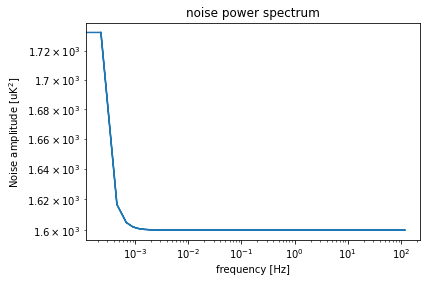

In [ ]:
def sim_noise_spec(nsamp, dt=.00416, fknee=0.1, alpha=3, sigma=42.5):
    """Build a simple atmosphere + white noise model, and return it
    as a power spectrum."""
    freq   = np.abs(np.fft.fftfreq(nsamp, dt))
    return (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2



noise_spec_lr = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.0001, alpha=3, sigma=40)
noise_spec_ud = sim_noise_spec(point_ud.shape[-1], dt=.00416, fknee=0.0001, alpha=3, sigma=40)
freq   = np.abs(np.fft.fftfreq(point_lr.shape[-1], .00416))

plt.loglog(freq,noise_spec_ud)
plt.title("noise power spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Noise amplitude [uK$^{2}$]")
plt.show()


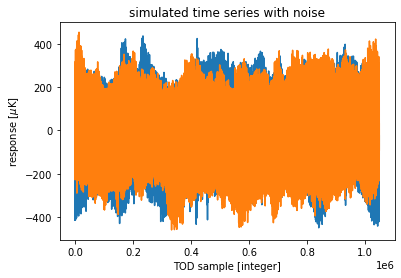

In [ ]:
def Observe_map(map, point):
    """Pointing matrix: Project map to tod"""
    point = np.round(point).astype(int)
    return map[point[0],point[1]]  ## return the value of the map at each pointing, this forms the simulated time stream


def sim_tod(map, point, noise_spec):
    """Simulate a noisy TOD using the model d = Pm + n"""
    tod    = Observe_map(map, point)
    rand   = np.fft.fft(np.random.standard_normal(tod.shape[-1]))
    fnoise = rand * noise_spec**0.5
    tod   += np.fft.ifft(fnoise).real
    return tod



tod_lr = sim_tod(SKY_MAP, point_lr, noise_spec_lr)
tod_ud = sim_tod(SKY_MAP, point_ud, noise_spec_ud)

plt.plot(tod_lr)
plt.plot(tod_ud)
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

Generating noisy TOD simulations


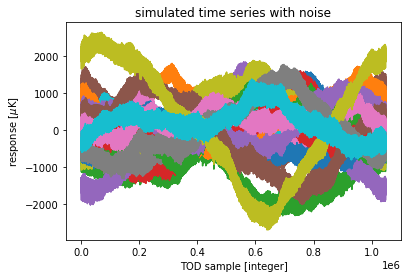

In [ ]:
def sim_dataset(map, num_data=10, dt=.00416, fknee=0.0001, alpha=3, sigma=40):
    """Simulate a dataset consisting of num_data scans across the sky.
    Returns a list of Data objects, each of which contains the tod,
    the pointing and the noise spectrum."""
    res = []
    for i in range(num_data):
        point = sim_pointing(map, i % 2)
        noise_spec = sim_noise_spec(point.shape[-1], dt=dt, fknee=fknee, alpha=alpha, sigma=sigma)
        tod = sim_tod(map, point, noise_spec)
        res.append(Data(tod, point, noise_spec))
    return res


class Data:
    def __init__(self, tod, point, noise_spec):
        self.tod   = tod
        self.point = point
        self.noise_spec = noise_spec




print("Generating noisy TOD simulations")
dataset  = sim_dataset(SKY_MAP,num_data=20, dt=.00416, fknee=0.1, alpha=3, sigma=40)
for data in dataset:
    plt.plot(data.tod)
    
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

In [ ]:

def solve_binned_average(dataset, shape):
    """Solve the simplified mapmaking equation Ax=b,
    where A = P'P and b = P'd, e.g. ignoring noise
    properties such as correlations."""
    rhs  = np.zeros(shape)
    hits = np.zeros(shape)
    for data in dataset:
        rhs  += PT(data.tod,    data.point, shape)
        hits += PT(data.tod*0+1, data.point, shape)
    return rhs/hits

def PT(tod, point, shape):
    """Transpose pointing matrix."""
    point = np.round(point).astype(int)
    #print(point.shape)
    point_flat = np.ravel_multi_index(point, shape[-2:])
    #print(point.shape)
    map = np.bincount(point_flat, tod, minlength=shape[-2]*shape[-1])
    map = map.reshape(shape[-2:])
    return map


def solve_full(dataset, shape, niter=20, verbose=True):
    """Solve the full map-making equation
    Ax=b, where A = P'N"P and b = P'N"d."""
    # Set up our A matrix. We don't compute
    # explicitly because it's too big. Instead,
    # we define it as a function that can be applied
    # to a vector x. We will then use Conjugate Gradients
    # to invert it.
    def A(x):
        # x is 1d because the conjugate gradient solver works
        # on 1d arrays. So start by expanding it to 2d.
        x   = x.reshape(shape)
        res = x*0
        for data in dataset:
            tod  = Observe_map(x, data.point)
            tod  = mul_inv_noise(tod, data.noise_spec)
            res += PT(tod, data.point, shape)
            #print("Print A:",res.reshape(-1))
        return res.reshape(-1)
    
    # Build our right-hand side b
    b = np.zeros(shape)
    for data in dataset:
        tod = mul_inv_noise(data.tod, data.noise_spec)
        b  += PT(tod, data.point, shape)
    # And solve
    cg = CG(A, b.reshape(-1))

    while cg.i < niter:
        cg.step()
        if verbose: print("iteration: %4d conjugate gradient error: %15.7e" % (cg.i, cg.err))
    return cg.x.reshape(shape)



def mul_inv_noise(tod, noise_spec):
    """Multiply by the inverse noise matrix. We assume that the noise
    is stationary, which means that it can be represented by a simple
    power spectrum noise_spec. This function is used to apply inverse
    variance weighting to the data."""
    ftod  = np.fft.fft(tod)
    ftod /= noise_spec
    return np.fft.ifft(ftod).real


def default_M(x):     return np.copy(x)
def default_dot(a,b): return a.dot(np.conj(b))
class CG:
    """A simple Preconditioned Conjugate gradients solver. Solves
    the equation system Ax=b."""
    def __init__(self, A, b, x0=None, M=default_M, dot=default_dot):
        """Initialize a solver for the system Ax=b, with a starting guess of x0 (0
        if not provided). Vectors b and x0 must provide addition and multiplication,
        as well as the .copy() method, such as provided by numpy arrays. The
        preconditioner is given by M. A and M must be functors acting on vectors
        and returning vectors. The dot product may be manually specified using the
        dot argument. This is useful for MPI-parallelization, for example."""
        # Init parameters
        self.A   = A
        self.b   = b
        self.M   = M
        self.dot = dot
        if x0 is None:
            self.x = b*0
            self.r = b
        else:
            self.x   = x0.copy()
            self.r   = b-self.A(self.x)
        # Internal work variables
        n = b.size
        self.z   = self.M(self.r)
        self.rz  = self.dot(self.r, self.z)
        self.rz0 = float(self.rz)
        self.p   = self.z
        self.err = np.inf
        self.d   = 4
        self.arz = []
        self.i   = 0
    def step(self):
        """Take a single step in the iteration. Results in .x, .i
        and .err being updated. To solve the system, call step() in
        a loop until you are satisfied with the accuracy. The result
        can then be read off from .x."""
        Ap = self.A(self.p)
        alpha = self.rz/self.dot(self.p, Ap)
        self.x += alpha*self.p
        self.r -= alpha*Ap
        self.z = self.M(self.r)
        next_rz = self.dot(self.r, self.z)
        self.err = next_rz/self.rz0
        beta = next_rz/self.rz
        self.rz = next_rz
        self.p = self.z + beta*self.p
        self.arz.append(self.rz*alpha)
        self.i += 1

print("Solving for map while taking noise correlations into account")
map_full  = solve_full(dataset, SKY_MAP.shape,niter=10)


Solving for map while taking noise correlations into account
iteration:    1 conjugate gradient error:   1.3616763e-02
iteration:    2 conjugate gradient error:   1.0259467e-03
iteration:    3 conjugate gradient error:   5.0629397e-05
iteration:    4 conjugate gradient error:   1.1287396e-05
iteration:    5 conjugate gradient error:   1.2450017e-07
iteration:    6 conjugate gradient error:   1.0044376e-08
iteration:    7 conjugate gradient error:   1.5749641e-10
iteration:    8 conjugate gradient error:   9.8514462e-13
iteration:    9 conjugate gradient error:   6.5769306e-14
iteration:   10 conjugate gradient error:   1.5967258e-15


map mean: 5.231904591951331e-06 map rms: 92.71821070864843


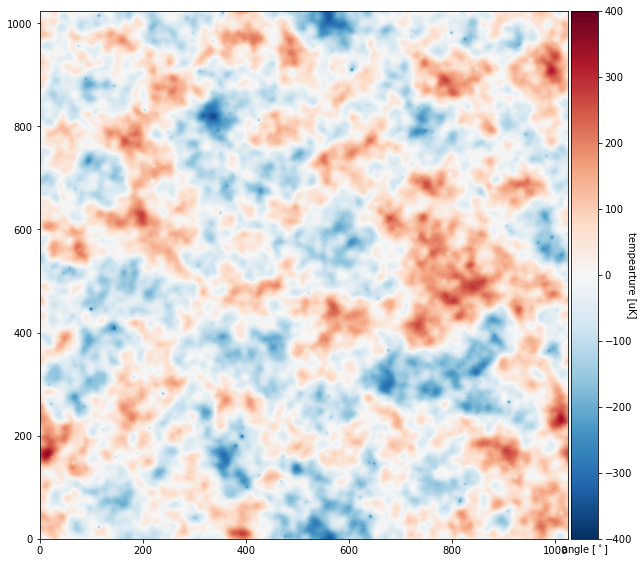

map mean: 10.416396627150577 map rms: 8.956043179834314


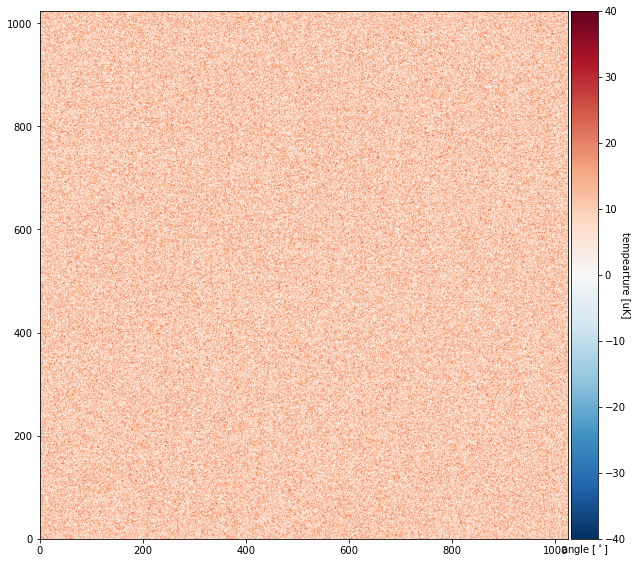

In [ ]:
p=Plot_CMB_Map(map_full,-400, 400, X_width, Y_width)
p=Plot_CMB_Map(map_full-SKY_MAP,-40, 40, X_width, Y_width)

Exercise: The map reconstructed with the conjugate gradient technique, takes into account two different set of scanning strategies: Up-Down and Left-Right.

Now Consider to use only one kind of scanning strategy, and reconstruct the map with the same number of data!

Question:: How do the residuals map change? Despite of the equal number of data and hits on the same pixel, may you explain the residual correlation?
